In [2]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko
from tqdm import tqdm
import seaborn as sns
import pandas as pd

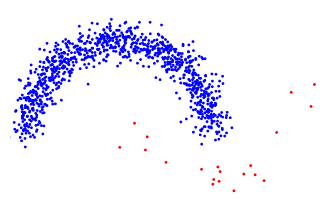

In [3]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = torch.cat([
        torch.pi * torch.rand(n),
        torch.pi * torch.rand(n // 50) + torch.pi,
    ])
    label = (theta > torch.pi).float()

    x = torch.stack((
        torch.cos(theta) + label - 1 / 2,
        torch.sin(theta) + label / 2 - 1 / 4,
    ), axis=-1)

    return torch.normal(x, sigma), label

samples, labels = two_moons(1000)

plt.figure(figsize=(4, 4))
plt.scatter(*samples.T, s=1, c=labels, cmap='bwr')
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect('equal')
plt.savefig('images/two_moons.png', dpi=1000)

In [4]:
nominal = samples[labels == 0]
failure = samples[labels == 1]

In [93]:
# Train single NSF with KL regularization
beta = 0.01
flow_nsf_beta_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_failure = zuko.flows.NSF(features=2, hidden_features=(64, 64))
nominal_optimizer = torch.optim.Adam(flow_nsf_beta_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_failure.parameters(), lr=1e-3)

for epoch in range(500):
    nominal_optimizer.zero_grad()
    failure_optimizer.zero_grad()

    loss_nominal = -flow_nsf_beta_nominal().log_prob(nominal).mean()

    loss_nominal.backward()
    nominal_optimizer.step()

    p_dist = flow_nsf_beta_failure()
    q_dist = flow_nsf_beta_nominal()
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((100,))
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    loss_failure = -flow_nsf_beta_failure().log_prob(failure).mean() + beta * kl_divergence
    loss_failure.backward()
    failure_optimizer.step()

    if epoch % 50 == 0:
        print(f'({epoch})', loss_nominal.detach().item(), ", ", loss_failure.detach().item())

(0utils.) 2.432365894317627 ,  2.500333309173584
(50utils.) 0.34667760133743286 ,  0.1756797730922699
(100utils.) 0.28810447454452515 ,  -0.31866762042045593
(150utils.) 0.27479809522628784 ,  -0.5100117921829224
(200utils.) 0.27094247937202454 ,  -0.48181402683258057
(250utils.) 0.2610872983932495 ,  -0.5960591435432434
(300utils.) 0.25994035601615906 ,  -0.6618546843528748
(350utils.) 0.25530150532722473 ,  -0.7548021674156189
(400utils.) 0.2503383755683899 ,  -0.5420626997947693
(450utils.) 0.25128886103630066 ,  -0.6165796518325806


In [34]:
# Train calibrated NSF
flow_nsf_beta_calibrated_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_calibrated_failure = zuko.flows.NSF(features=2, context=1, hidden_features=(64, 64))
nominal_optimizer = torch.optim.Adam(flow_nsf_beta_calibrated_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_calibrated_failure.parameters(), lr=1e-3)

pbar = tqdm(range(500))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    failure_optimizer.zero_grad()

    loss_nominal = -flow_nsf_beta_calibrated_nominal().log_prob(nominal).mean()

    loss_nominal.backward()
    nominal_optimizer.step()

    loss_failure = torch.tensor(0.0)

    for beta in torch.tensor([1e-2, 1e-1, 0.2, 0.3, 0.5]):
        p_dist = flow_nsf_beta_calibrated_failure(beta.reshape(-1))
        q_dist = flow_nsf_beta_calibrated_nominal()
        p_samples, p_logprobs = p_dist.rsample_and_log_prob((1000,))
        q_logprobs = q_dist.log_prob(p_samples)
        q_prob = torch.exp(q_logprobs).mean(dim=0)
        
        # kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)
        # loss_failure += -p_dist.log_prob(failure).mean() + beta * kl_divergence
        loss_failure += -p_dist.log_prob(failure).mean() + torch.nn.functional.relu(beta - q_prob) / beta

    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(f'({epoch}) {loss_nominal.detach().item():.3f}, {loss_failure.detach().item():.3f}')

(499) 0.2582355737686157, -1.381325364112854: 100%|██████████| 500/500 [02:07<00:00,  3.93it/s]    


In [35]:
for beta in torch.tensor([1e-2, 1e-1, 0.2, 0.3, 0.5]):
    p_dist = flow_nsf_beta_calibrated_failure(beta.reshape(-1))
    q_dist = flow_nsf_beta_calibrated_nominal()
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((1000,))
    q_logprobs = q_dist.log_prob(p_samples)
    q_prob = torch.exp(q_logprobs).mean(dim=0)
    loss = torch.nn.functional.relu(beta - q_prob) / beta
    print(f'beta = {beta}, q_prob = {q_prob.detach().item()}, loss = {loss.detach().item()}')

beta = 0.009999999776482582, q_prob = 0.08293645083904266, loss = 0.0
beta = 0.10000000149011612, q_prob = 0.12326455861330032, loss = 0.0
beta = 0.20000000298023224, q_prob = 0.20104138553142548, loss = 0.0
beta = 0.30000001192092896, q_prob = 0.30918970704078674, loss = 0.0
beta = 0.5, q_prob = 0.5010961890220642, loss = 0.0


In [116]:
# Train stacked CNF
nominal_flow_cnf_stacked = zuko.flows.CNF(features=2, hidden_features=(64, 64))
failure_flow_cnf_stacked = zuko.flows.CNF(features=2, hidden_features=(64, 64))
failure_flow_cnf_stacked.base = nominal_flow_cnf_stacked

failure_flow_cnf_stacked.transform.times = torch.tensor([0.0, 1.0])

nominal_optimizer = torch.optim.Adam(nominal_flow_cnf_stacked.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(failure_flow_cnf_stacked.transform.parameters(), lr=1e-3)

pbar = tqdm(range(500))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    loss_nominal = -nominal_flow_cnf_stacked().log_prob(nominal).mean()
    loss_nominal.backward()
    nominal_optimizer.step()

    failure_optimizer.zero_grad()
    loss_failure = -failure_flow_cnf_stacked().log_prob(failure).mean()

    # Add spectral regularization
    spectral_norm = 1.0
    for layer in failure_flow_cnf_stacked.transform.ode:
        if isinstance(layer, zuko.nn.Linear):
            spectral_norm *= torch.linalg.svdvals(layer.weight)[0]

    loss_failure = loss_failure + 1e-1 * spectral_norm

    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(f'({epoch}) ln: {loss_nominal.detach().item():.3f}, lf: {loss_failure.detach().item():.3f}')


(499) ln: 0.290, lf: 3.350: 100%|██████████| 500/500 [07:12<00:00,  1.16it/s]


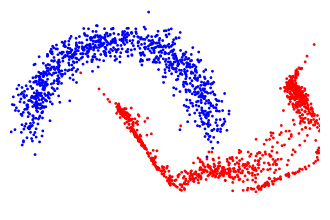

In [118]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
nominal_samples = flow_nsf_beta_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_failure().sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)
ax.scatter(*samples.T, s=1, c=labels, cmap='bwr')
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect('equal')
plt.savefig('images/two_moons_nsf_context_beta.png', dpi=1000)

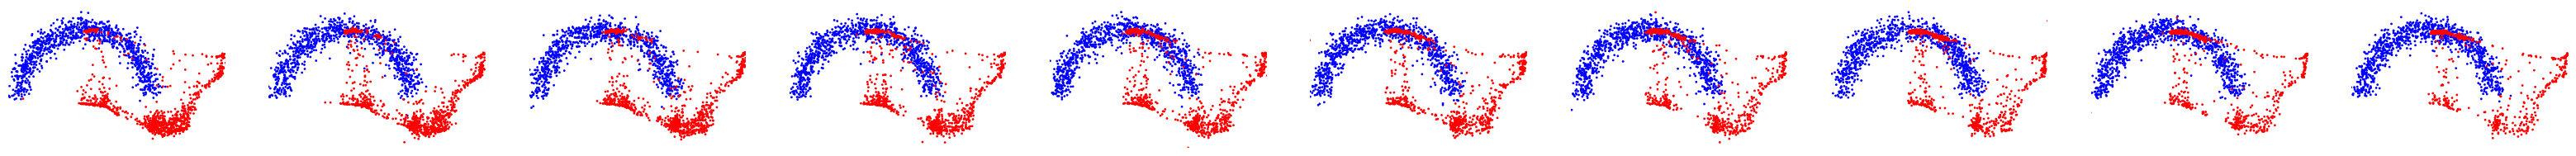

In [36]:
_, axs = plt.subplots(1, 10, figsize=(4 * 10, 4))
for i in range(10):
    t = torch.tensor([i / 10.0])

    nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
    nominal_labels = torch.tensor([0.0]).expand(1_000)
    failure_samples = flow_nsf_beta_calibrated_failure(t).sample((1_000,))
    failure_labels = torch.tensor([1.0]).expand(1_000)
    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[i].scatter(*samples.T, s=1, c=labels, cmap='bwr')
    # Turn off axis ticks
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis('off')
    axs[i].set_ylim([-1.1, 1.1])
    axs[i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[i].set_aspect('equal')
    # plt.savefig('images/two_moons_cnf_stacked.png', dpi=1000)

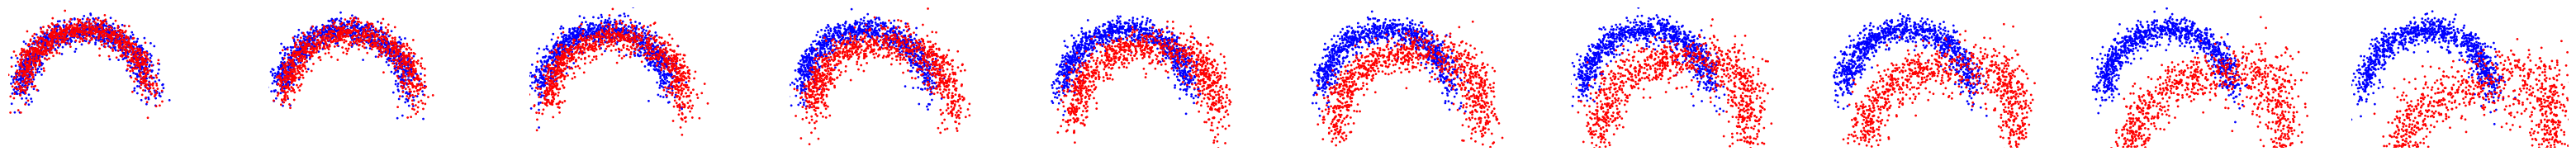

In [124]:
_, axs = plt.subplots(1, 10, figsize=(4 * 10, 4))
for i in range(10):
    t = torch.tensor([i / 10.0])
    failure_flow_cnf_stacked.transform.times = torch.tensor([0.0, t])

    nominal_samples = nominal_flow_cnf_stacked().sample((1_000,))
    nominal_labels = torch.tensor([0.0]).expand(1_000)
    failure_samples = failure_flow_cnf_stacked().sample((1_000,))
    failure_labels = torch.tensor([1.0]).expand(1_000)
    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[i].scatter(*samples.T, s=1, c=labels, cmap='bwr')
    # Turn off axis ticks
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis('off')
    axs[i].set_ylim([-1.1, 1.1])
    axs[i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[i].set_aspect('equal')
    # plt.savefig('images/two_moons_cnf_stacked.png', dpi=1000)

In [38]:
# # Plot a histogram of an isotropic Gaussian
# _, ax = plt.subplots(1, 1, figsize=(4, 4))
# # samples = torch.randn((1_000_000, 2))

# for t in [0.1, 0.25, 0.5, 0.75, 1.0]:
#     failure_flow_cnf_stacked.transform.times = torch.tensor([0.0, t])
#     samples = failure_flow_cnf_stacked().sample((200_000,))
#     plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
#     # Turn off axis ticks
#     plt.xticks([])
#     plt.yticks([])
#     plt.axis('off')
#     plt.savefig(f'images/failure_flow_{t:.2f}.png', dpi=300)

# failure_flow_cnf_stacked.transform.times = torch.tensor([0.0, 1.0])

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


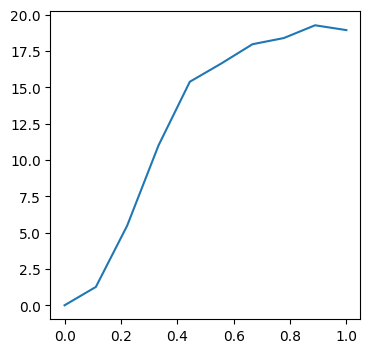

In [108]:
@torch.no_grad()
def compute_kl(p, q):
    p_dist = p()
    q_dist = q()
    p_samples = p_dist.rsample((1_000,))
    p_logprobs = p_dist.log_prob(p_samples)
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)
    
    return kl_divergence


ts = torch.linspace(0.0, 1.0, 10)
kls = []
for t in tqdm(ts):
    failure_flow_cnf_stacked.transform.times = torch.tensor([0.0, t])
    kls.append(compute_kl(failure_flow_cnf_stacked, nominal_flow_cnf_stacked))

plt.figure(figsize=(4, 4))
plt.plot(ts, kls)

L:  1.3038541078567505
E[||grad log q||] =  0.8644023537635803
KL: 0.1752893477678299, bound: 2.1682565212249756


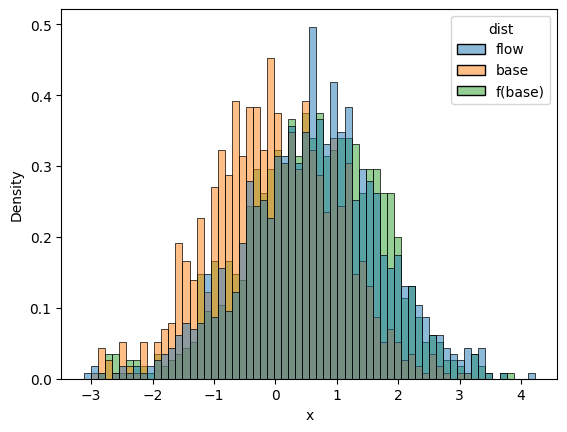

In [88]:
def compute_kl(p, q):
    p_dist = p()
    q_dist = q()
    p_samples = p_dist.rsample((10_000,))
    p_logprobs = p_dist.log_prob(p_samples)
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)
    
    return kl_divergence

n = 1
g_ub = 1.0

q = zuko.flows.CNF(features=n, freqs=0, hidden_features=(64, 64))
q.transform.ode = torch.nn.Sequential(zuko.nn.Linear(1, 8), torch.nn.Tanh(), torch.nn.Linear(8, 1), torch.nn.Tanh(), zuko.nn.Linear(1, 1, bias=False))
q.transform.ode[-1].weight.data = torch.tensor([[g_ub]])
p = q.base
delta_t = q.transform.times[1] - q.transform.times[0]

q_samples = q().sample((1000,))
p_samples = p().sample((1000,))
f_samples = q.transform().inv(p_samples)
samples = torch.cat((q_samples, p_samples, f_samples), axis=0).squeeze().detach()
labels = ["flow"] * 1000 + ["base"] * 1000 + ["f(base)"] * 1000
df = pd.DataFrame({"x": samples.numpy(), "dist": labels})
sns.histplot(data=df, x="x", hue="dist", bins=64, stat="density", common_norm=False)

# Compute the KL bound
L = 1.0
for layer in q.transform.ode:
    if isinstance(layer, zuko.nn.Linear):
        spectral_norm = torch.linalg.svdvals(layer.weight.data)[0]
        L *= spectral_norm
print("L: ", L.item())

# Gaussian-specific
p_samples = p().sample((10_000,))
f_inv = q.transform()  # quirk of how zuko defines the flow; the transform goes from the flow to the base
grad_log_q = torch.norm(f_inv(p_samples), dim=-1).mean().item()
print("E[||grad log q||] = ", grad_log_q)

kl_bound = delta_t * (n * L + g_ub * grad_log_q)

kl = compute_kl(p, q)
print(f"KL: {kl}, bound: {kl_bound}")

In [16]:
q.transform.ode(torch.tensor([0.0]))

tensor([3.0464], grad_fn=<SqueezeBackward4>)

In [20]:
import numpy as np
4 * np.tanh(1.0)

3.0463766238230594